In [1]:
from workshop_utils import *
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Global Edit Counts
This query searches only the changesets table getting basic statistics
```sql
SELECT
  changesets.user, min(created_at) AS first_edit, 
  max(created_at) AS last_edit, 
  sum(num_changes) AS total_edits
FROM 
  changesets
GROUP BY 
  changesets.user 
```

In [2]:
df = load_dataframe_from_s3('https://us-east-2.console.aws.amazon.com/athena/query/results/412cb09c-eb4d-4986-beca-2641e05ce8a6/csv')

data/412cb09c-eb4d-4986-beca-2641e05ce8a6.csv
Creating dataframe... done.  Found 1,350,778 rows

In [3]:
df.set_index('user', inplace=True)
df.first_edit = df.first_edit.apply(lambda x: pd.Timestamp(x).date())
df.last_edit = df.last_edit.apply(lambda x: pd.Timestamp(x).date())

In [4]:
df['lifespan'] = df.apply(lambda row: row.last_edit - row.first_edit, axis=1)

In [5]:
df.head(2)

,first_edit,last_edit,total_edits,lifespan
user,,,,
Wildwater,2018-05-28,2019-08-18,355588,447 days
maher_elgammal,2019-05-14,2019-08-08,117166,86 days


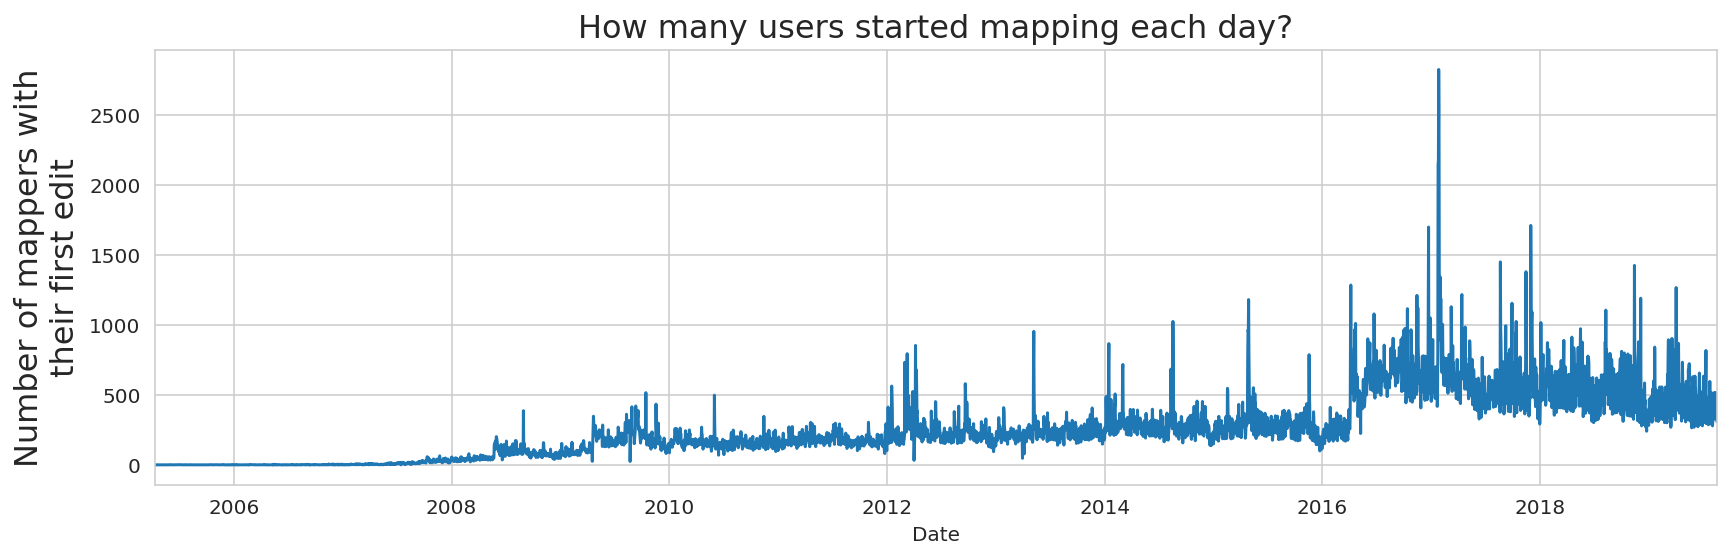

In [6]:
sns.set_style('whitegrid')
ax = df.groupby('first_edit').aggregate('count')['total_edits'].plot(figsize=(14,4))
ax.set_xlabel("Date"); 
ax.set_ylabel("Number of mappers with\ntheir first edit", fontsize=16)
ax.set_title("How many users started mapping each day?", fontsize=16);

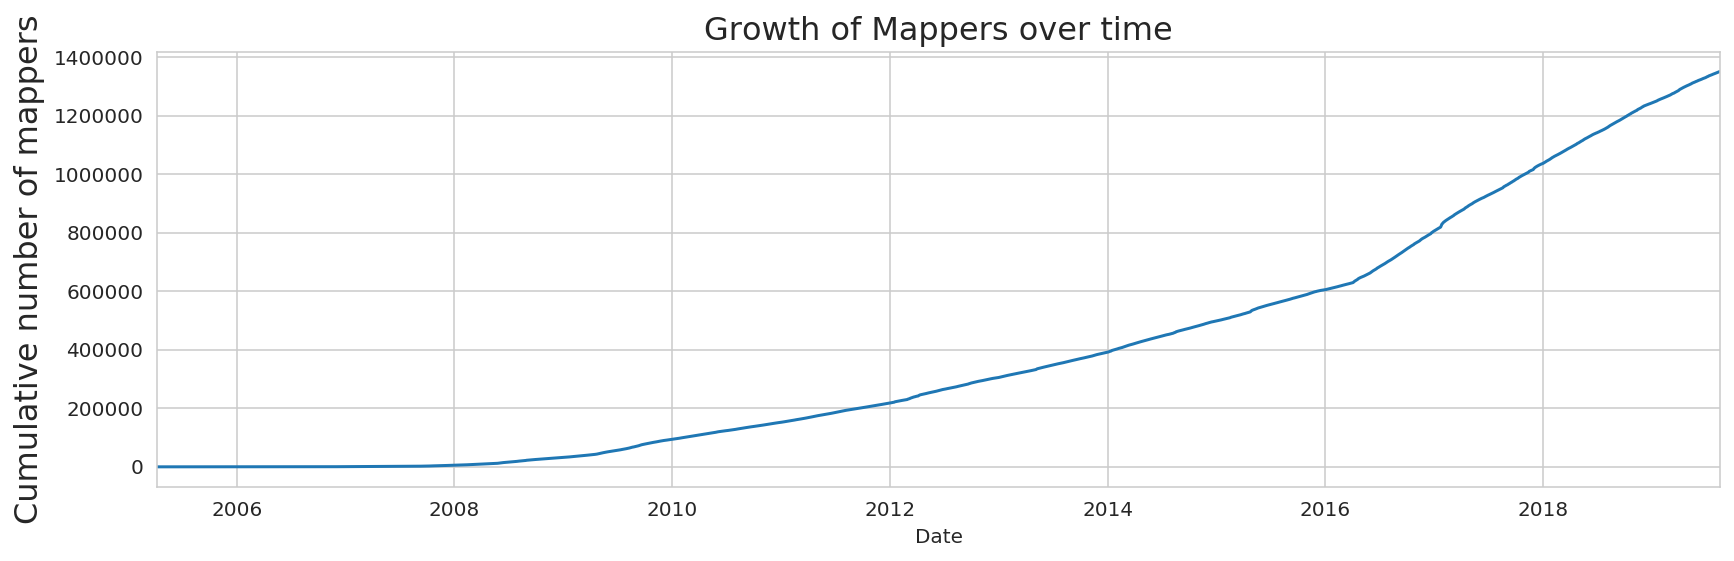

In [7]:
ax = df.groupby('first_edit').aggregate('count')['total_edits'].cumsum().plot(figsize=(14,4))
ax.set_xlabel("Date"); 
ax.set_ylabel("Cumulative number of mappers", fontsize=16)
ax.set_title("Growth of Mappers over time", fontsize=16);

In [8]:
print("Explore at the 2017 spike: ")
df.groupby('first_edit').aggregate('count').sort_values(by='total_edits',ascending=False).head()

Explore at the 2017 spike: 


,last_edit,total_edits,lifespan
first_edit,,,
2017-01-26,2822,2822,2822
2017-01-27,2528,2528,2528
2017-01-25,2176,2176,2176
2017-01-24,2146,2146,2146
2017-12-01,1709,1709,1709


In [9]:
df['lifespan_hours'] = df.lifespan.apply(lambda x: x.total_seconds()/3600)

In [10]:
df.head(2)

,first_edit,last_edit,total_edits,lifespan,lifespan_hours
user,,,,,
Wildwater,2018-05-28,2019-08-18,355588,447 days,10728.0
maher_elgammal,2019-05-14,2019-08-08,117166,86 days,2064.0


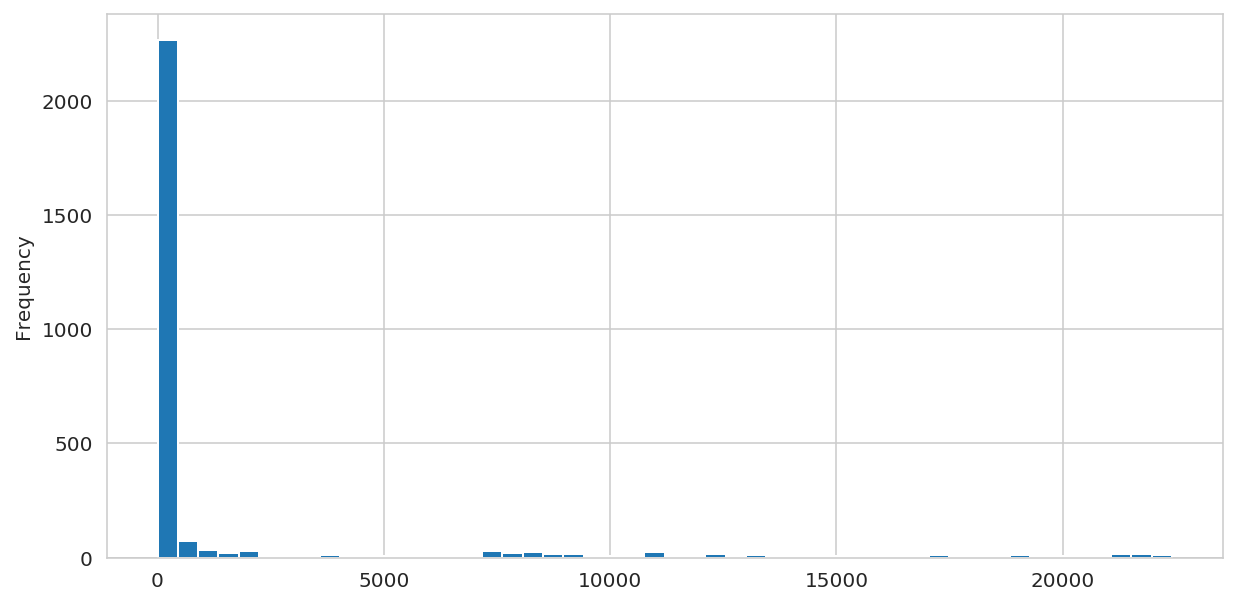

In [11]:
ax = df[ df.first_edit == pd.Timestamp('2017-01-26').date()][
    'lifespan_hours'].plot(kind='hist',bins=50,figsize=(10,5))

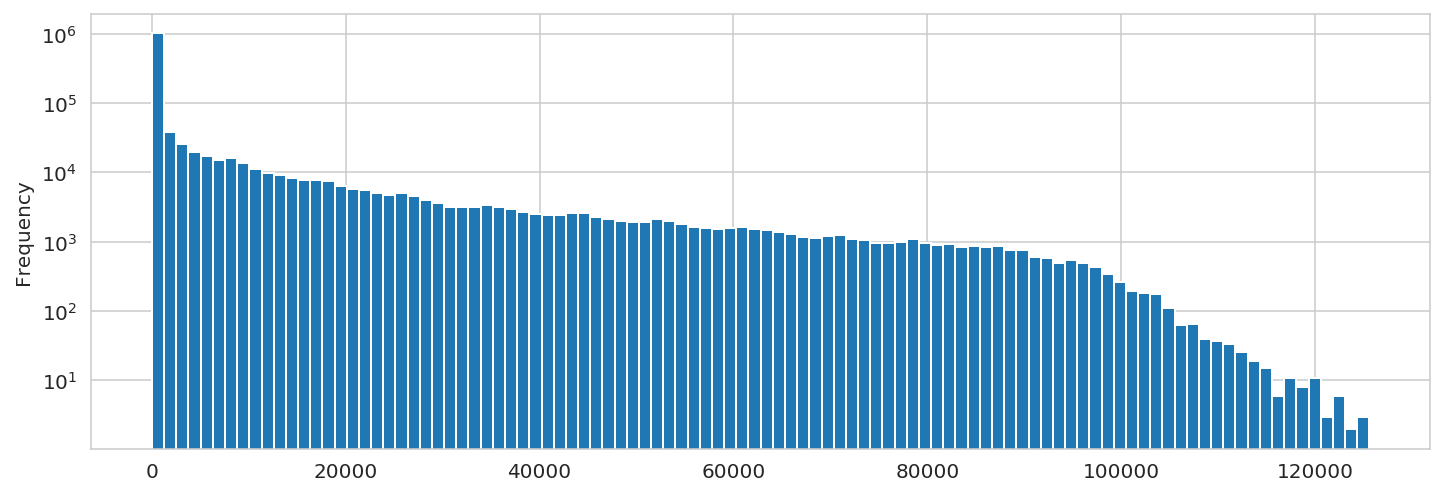

In [12]:
ax = df.lifespan_hours.plot(kind='hist',bins=100,figsize=(12,4))
ax.set_yscale('log')

# Compare to HOT editors

```sql
SELECT
  changesets.user, min(created_at) AS first_edit, 
  max(created_at) AS last_edit, 
  sum(num_changes) AS total_edits
FROM 
  changesets
WHERE
  changesets.tags['comment'] LIKE '%hotosm%' -- hotosm changesets only
GROUP BY 
  changesets.user 
```

In [13]:
# How does this compare to only edits from HOT changesets?
hot_editors = load_dataframe_from_s3('https://us-east-2.console.aws.amazon.com/athena/query/results/43adbc69-9c9f-4b35-9db9-6d128023fde6/csv')

data/43adbc69-9c9f-4b35-9db9-6d128023fde6.csv
Creating dataframe... done.  Found 140,896 rows

In [14]:
hot_editors.set_index('user', inplace=True)
hot_editors.first_edit = hot_editors.first_edit.apply(lambda x: pd.Timestamp(x).date())
hot_editors.last_edit = hot_editors.last_edit.apply(lambda x: pd.Timestamp(x).date())

In [15]:
hot_editors['lifespan'] = df.apply(lambda row: row.last_edit - row.first_edit, axis=1)

In [16]:
hot_editors.head(2)

,first_edit,last_edit,total_edits,lifespan
user,,,,
m902,2014-11-07,2017-09-27,2453301,3300 days
alex7113,2014-10-20,2015-05-08,18558,233 days


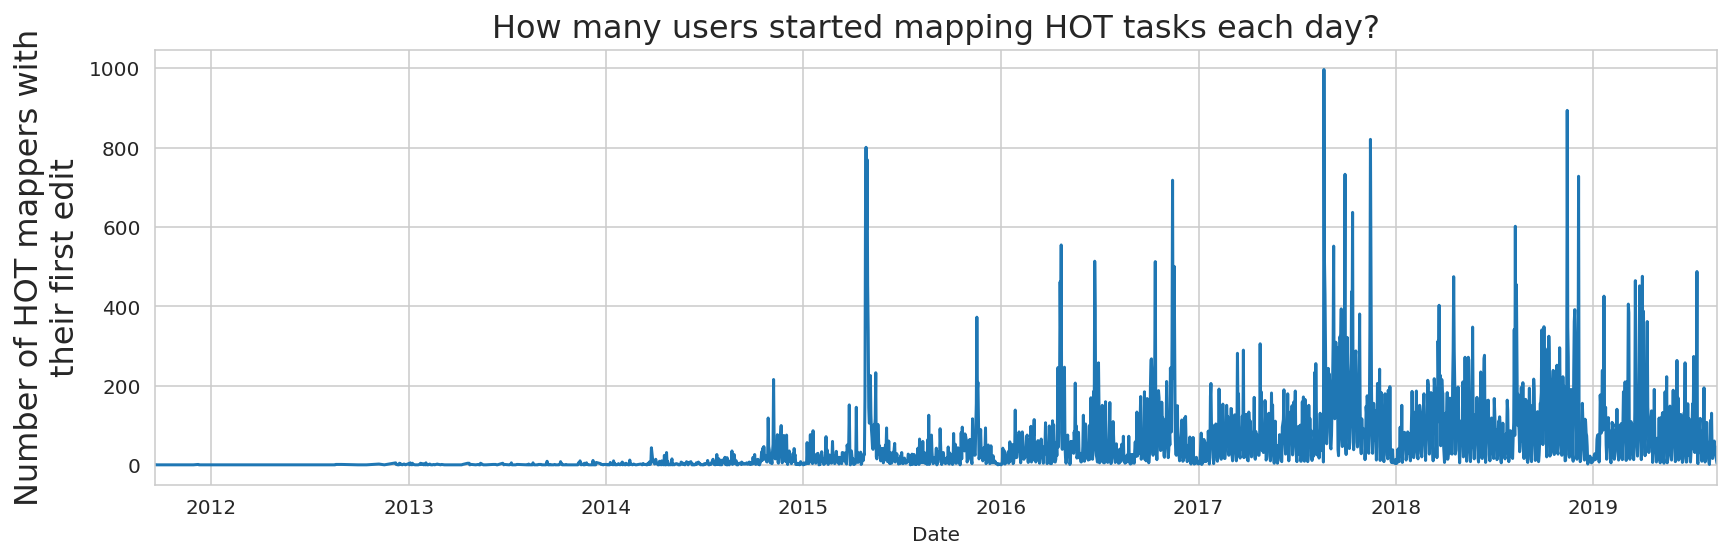

In [17]:
sns.set_style('whitegrid')
ax = hot_editors.groupby('first_edit').aggregate('count')['total_edits'].plot(figsize=(14,4))
ax.set_xlabel("Date"); 
ax.set_ylabel("Number of HOT mappers with\ntheir first edit", fontsize=16)
ax.set_title("How many users started mapping HOT tasks each day?", fontsize=16);

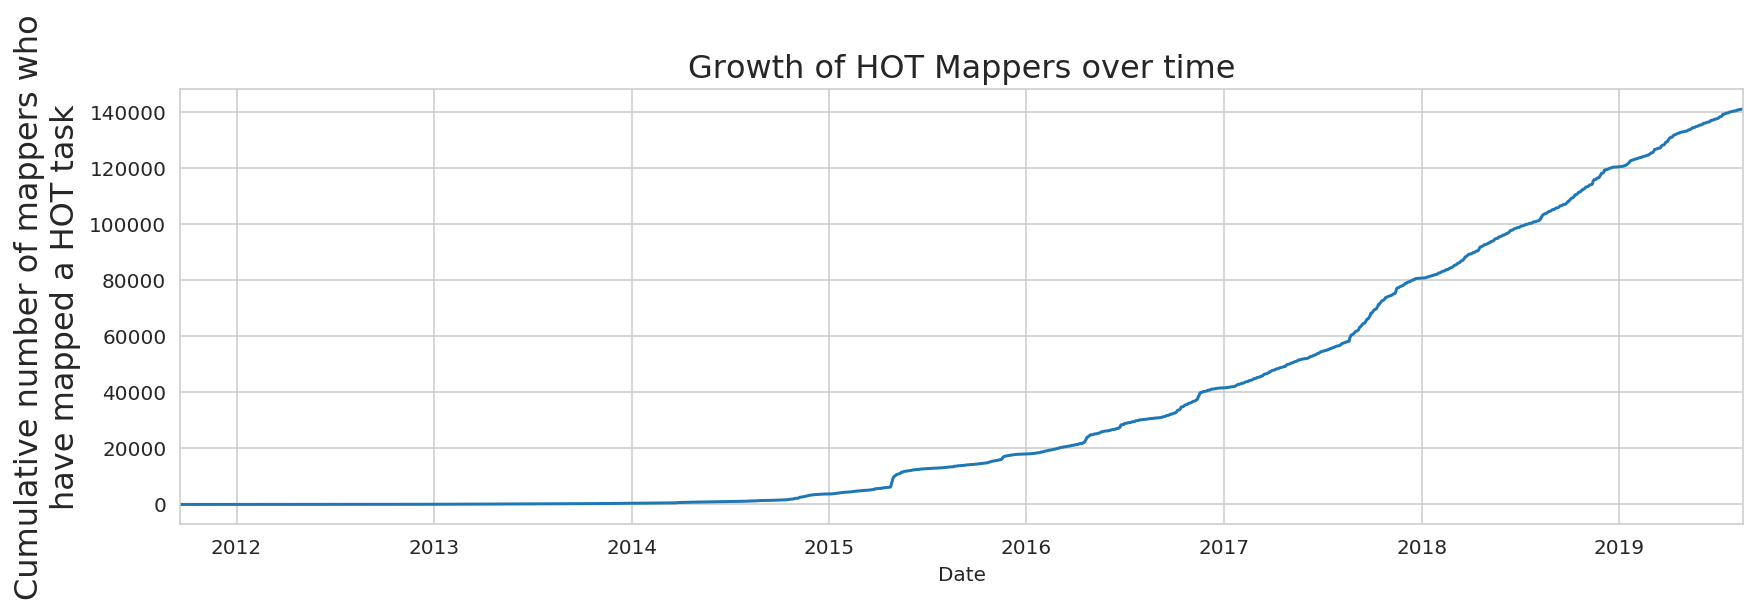

In [18]:
ax = hot_editors.groupby('first_edit').aggregate('count')['total_edits'].cumsum().plot(figsize=(14,4))
ax.set_xlabel("Date"); 
ax.set_ylabel("Cumulative number of mappers who\nhave mapped a HOT task", fontsize=16)
ax.set_title("Growth of HOT Mappers over time", fontsize=16);